In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
# get snippets
NTR = 30
T_SNPS = range(1, 320, 8)  # snippet lengths to fetch

ds = np.nan*np.zeros((len(T_SNPS), NTR))  # pairwise distances between neural song snippet representations

durs = []
masses = []

rs_final = []
rs_final_scrambled = []

# save some example snippets and responses
snp_xpls = []
snp_xpl_scrambleds = []

rs_full_xpl = []
rs_full_xpl_scrambled = []


for cT_SNP, T_SNP in enumerate(T_SNPS):
    sys.stdout.write(f'T_SNP {T_SNP}: ')
    
    NT_SNP = int(round(T_SNP*FPS))
    t_snp = np.arange(NT_SNP)*DT

    snps = []

    for csng, sng_full in enumerate(sngs_full):
        
        segs, bds = get_seg(sng_full > 0, min_gap=NT_SNP)
        segs = [sng_full[lb:ub] for lb, ub in bds]
        
        # keep fixed-length portions only of sufficiently long segments
        segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP)]
        
        snps.extend(segs)

    snps_scrambled = [snp[np.random.permutation(len(snp))] for snp in snps]
    
    snps = np.array(snps)
    nsnp = len(snps)
    
    snps_scrambled = np.array(snps_scrambled)

    sys.stdout.write(f'{nsnp} snippets')

    for ctr in range(NTR):
        sys.stdout.write('.')
        isnps = np.random.choice(range(len(snps)), 2, replace=False)
        r_pair = []

        for isnp in isnps:
            # get neural response
            snp = snps[isnp]
            i_s = (snp == 1).astype(float)
            i_p = (snp == 2).astype(float)

            t_snp = np.arange(len(snp))*DT

            rs = smlt(i_s, i_p, tau_r, tau_a, x_s, x_p)[0]

            r_pair.append(rs[-1, :])
            
            rs_final.append(rs[-1, :])
            
            durs.append(T_SNP)
            masses.append(np.sum(snp > 0)*DT)
            
            # get neural response to scrambled snippet
            snp_scrambled = snps_scrambled[isnp]
            
            i_s_scrambled = (snp_scrambled == 1).astype(float)
            i_p_scrambled = (snp_scrambled == 2).astype(float)
            
            rs_scrambled = smlt(i_s_scrambled, i_p_scrambled, tau_r, tau_a, x_s, x_p)[0]
            
            rs_final_scrambled.append(rs_scrambled[-1, :])
            
            if np.random.rand() < .1:  # randomly save some examples
                snp_xpls.append(snp.copy())
                rs_full_xpl.append(rs.copy())
                
                snp_xpl_scrambleds.append(snp_scrambled.copy())
                rs_full_xpl_scrambled.append(rs_scrambled.copy())
                

        d = np.linalg.norm(r_pair[0] - r_pair[1])
        
        ds[cT_SNP, ctr] = d
    print('')
    
durs = np.array(durs)
masses = np.array(masses)

T_SNP 1: 4272 snippets..............................
T_SNP 9: 436 snippets..............................
T_SNP 17: 177 snippets..............................
T_SNP 25: 125 snippets..............................
T_SNP 33: 104 snippets..............................
T_SNP 41: 95 snippets..............................
T_SNP 49: 93 snippets..............................
T_SNP 57: 92 snippets..............................
T_SNP 65: 90 snippets..............................
T_SNP 73: 88 snippets..............................
T_SNP 81: 86 snippets..............................
T_SNP 89: 83 snippets..............................
T_SNP 97: 81 snippets..............................
T_SNP 105: 81 snippets..............................
T_SNP 113: 79 snippets..............................
T_SNP 121: 77 snippets..............................
T_SNP 129: 76 snippets..............................
T_SNP 137: 75 snippets..............................
T_SNP 145: 75 snippets..............................
T_

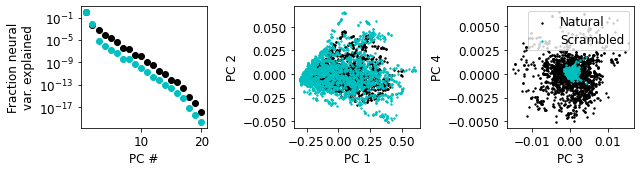

In [7]:
rs_final = np.array(rs_final)
pca = decomposition.PCA().fit(rs_final)
rs_final_pca = pca.transform(rs_final)

rs_final_scrambled = np.array(rs_final_scrambled)
pca_scrambled = decomposition.PCA().fit(rs_final_scrambled)
rs_final_scrambled_pca = pca_scrambled.transform(rs_final_scrambled)

fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), tight_layout=True)
axs[0].scatter(1+np.arange(N), pca.explained_variance_ratio_, c='k')
axs[0].scatter(1+np.arange(N), pca_scrambled.explained_variance_ratio_, c='c')
axs[0].set_yscale('log')

set_plot(axs[0], x_label='PC #', y_label='Fraction neural\nvar. explained')

axs[1].scatter(rs_final_pca[:, 0], rs_final_pca[:, 1], c='k', s=2)
axs[1].scatter(rs_final_scrambled_pca[:, 0], rs_final_scrambled_pca[:, 1], c='c', s=2)

set_plot(axs[1], x_label='PC 1', y_label='PC 2')

axs[2].scatter(rs_final_pca[:, 2], rs_final_pca[:, 3], c='k', s=2)
axs[2].scatter(rs_final_scrambled_pca[:, 2], rs_final_scrambled_pca[:, 3], c='c', s=2)

axs[2].legend(['Natural', 'Scrambled'])

set_plot(axs[2], x_label='PC 3', y_label='PC 4')

In [8]:
from time_stats import xcov_conv_tri

T_SNP = 300

NT_SNP = int(round(T_SNP*FPS))
t = np.arange(NT_SNP)*DT

snps = []

for csng, sng_full in enumerate(sngs_full):

    segs, bds = get_seg(sng_full > 0, min_gap=NT_SNP)
    segs = [sng_full[lb:ub] for lb, ub in bds]

    # keep fixed-length portions only of sufficiently long segments
    segs = [seg[:NT_SNP] for seg in segs if (len(seg) >= NT_SNP)]

    snps.extend(segs)

snps_scrambled = [snp[np.random.permutation(len(snp))] for snp in snps]

snps = np.array(snps)
nsnp = len(snps)

snps_scrambled = np.array(snps_scrambled)

In [9]:
IPCS = range(4)
rs_pca_all = []
rs_scrambled_pca_all = []

for snp, snp_scrambled in zip(snps, snps_scrambled):
    sys.stdout.write('.')
    
    rs = smlt(snp==1, snp==2, tau_r, tau_a, x_s, x_p)[0]
    rs_pca = pca.transform(rs)
    rs_pca_all.append(rs_pca)
    
    rs_scrambled = smlt(snp_scrambled==1, snp_scrambled==2, tau_r, tau_a, x_s, x_p)[0]
    rs_scrambled_pca = pca_scrambled.transform(rs_scrambled)
    rs_scrambled_pca_all.append(rs_scrambled_pca)

.........................................................

# Plot separation of neural song reprs projected onto each top PC

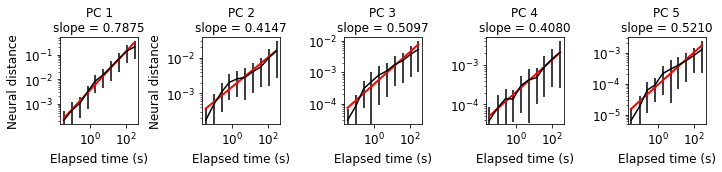

In [11]:
from disp import set_color, get_line_log

# plot traj separation over time after projecting onto each top PC
IPCS = [0, 1, 2, 3, 4]

fig, axs = plt.subplots(1, len(IPCS), figsize=(10, 2.5), tight_layout=True)

for cIPC, IPC in enumerate(IPCS):

    rs_ipc = np.nan*np.zeros((len(rs_pca_all), len(t)))

    for crs_pca, rs_pca in enumerate(rs_pca_all):
        rs_ipc[crs_pca, :] = rs_pca[:, IPC]

    mt = np.round(np.logspace(0, np.log10(len(t)-1), 10)).astype(int)
    
    # song separation
    NPAIR = 500

    ds = np.nan*np.zeros((NPAIR, len(t)))
    for cpair in range(NPAIR):
        idx_0, idx_1 = np.random.choice(np.arange(len(rs_ipc)), 2, replace=False)
        ds[cpair, :] = np.abs(rs_ipc[idx_0, :]-rs_ipc[idx_1, :])
    
    axs[cIPC].errorbar(t[mt], ds.mean(0)[mt], yerr=np.std(ds, axis=0)[mt], c='k')

    x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t[t>0], ds.mean(0)[t>0])

    axs[cIPC].plot(10**x_ln, 10**y_ln, c='r', lw=2)
    axs[cIPC].set_xscale('log')
    axs[cIPC].set_yscale('log')

    set_plot(axs[cIPC], x_label='Elapsed time (s)', title=f'PC {IPC+1}\nslope = {slp:.4f}')
    if cIPC < 2:
        set_plot(axs[cIPC], y_label='Neural distance')
        
fig.savefig('ms/4_pc_diffusion.svg')